# Super Resolution

Implementation of super resolution the following notebook is based on the article  
[Real-Time Single Image and Video Super-Resolution](https://arxiv.org/abs/1609.05158)  
[PDF](<Real-Time Single Image and Video Super-Resolution Using an Efﬁcient Sub-Pixel Convolutional Neural Network.pdf>)



## Import of modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision, torcheval
import os, sys, re

import PIL
import glob

from tqdm import tqdm
from torch.utils.data import DataLoader

# sys.path.append('supresolv')
import supresolv as sr

from supresolv.data import *
from supresolv.dataset import *
from supresolv.model import *

from torcheval.metrics.functional import peak_signal_noise_ratio, mean_squared_error
from skimage.metrics import structural_similarity as ssim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Model definition and loading

In [3]:
# dataset download
upscale_factor = 3
train_set = get_training_set(upscale_factor)
test_set = get_test_set(upscale_factor)

# creation of dataloaders
train_loader = DataLoader(
    train_set,
    batch_size=32,
    shuffle=True,
    pin_memory=True,
    pin_memory_device=device.type,
)
test_loader = DataLoader(test_set, batch_size=16, shuffle=True)

model = ESPCN(upscale_factor=upscale_factor)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
mse_loss = torch.nn.MSELoss()
cross_entropy_loss = torch.nn.CrossEntropyLoss()
l1_loss = torch.nn.L1Loss()



## Model Training

In [4]:
epochs: int = 1

model.to(device)
# model.train(True)
for epoch in tqdm(range(epochs), "Epoch"):

    # epoch training
    for input, target in train_loader:

        input, target = input.to(device), target.to(device)
        # zeros all gradients
        optimizer.zero_grad()

        # propagate input in nn
        output = model(input)

        # loss calculation
        # loss: torch.Tensor = l1_loss(output, target)
        loss: torch.Tensor = mse_loss(output, target)
        # loss: torch.Tensor = cross_entropy_loss(output, target)
        loss.backward()

        # parameters update
        optimizer.step()

    # save the model for each epoch
    torch.save(
        model,
        os.path.join(
            ".models",
            f"model-{epoch+1:03d}-ups-{upscale_factor:02d}-mse.pth",
        ),
    )

Epoch: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


## Model Testing & Evaluation
We verify the evolution of the model's performance with the number of 

### Performance

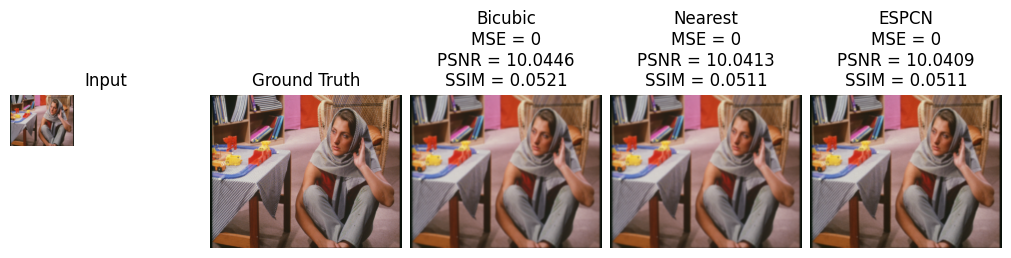

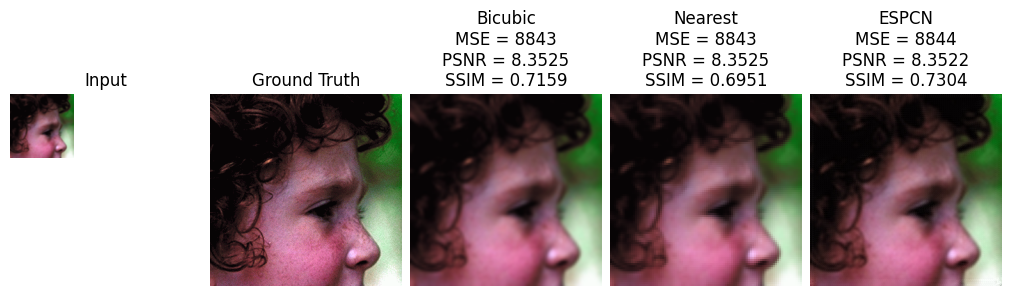

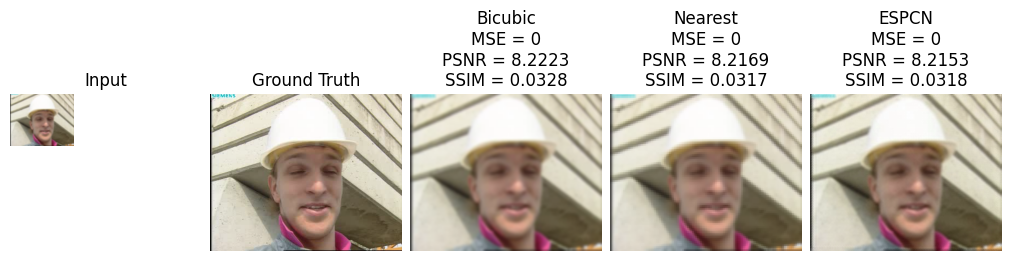

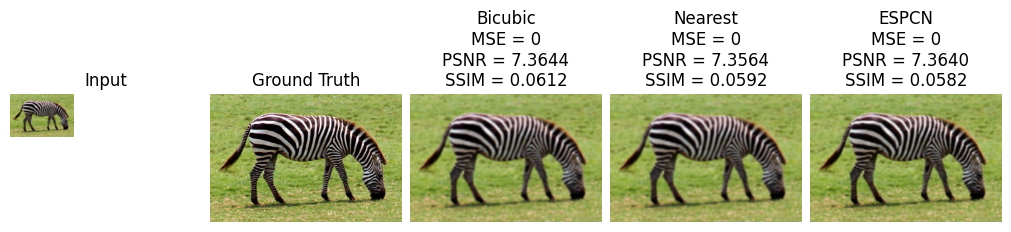

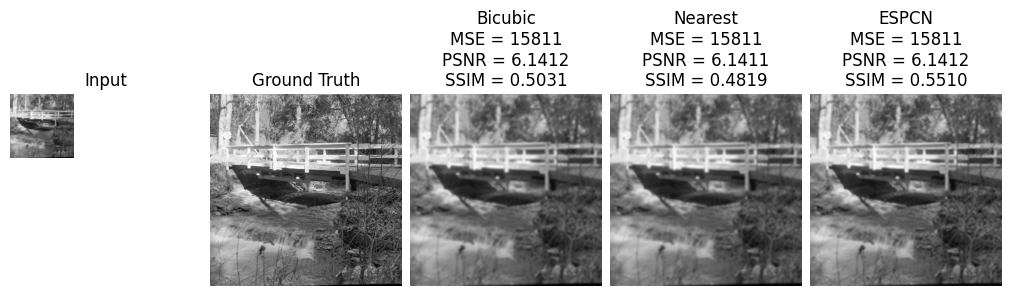

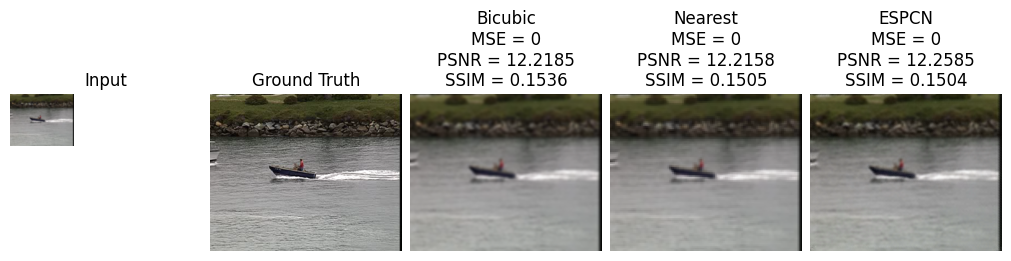

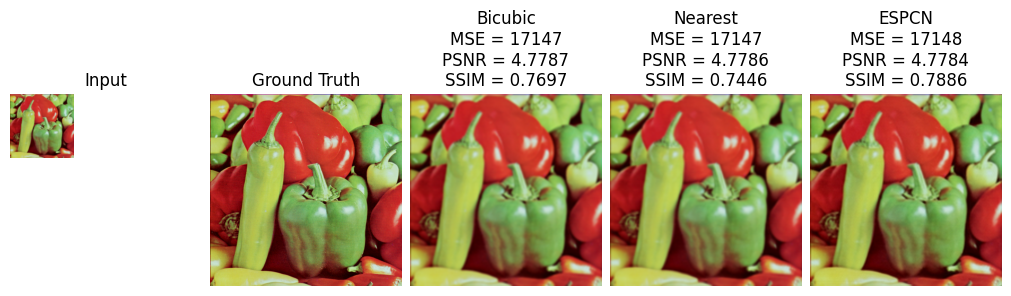

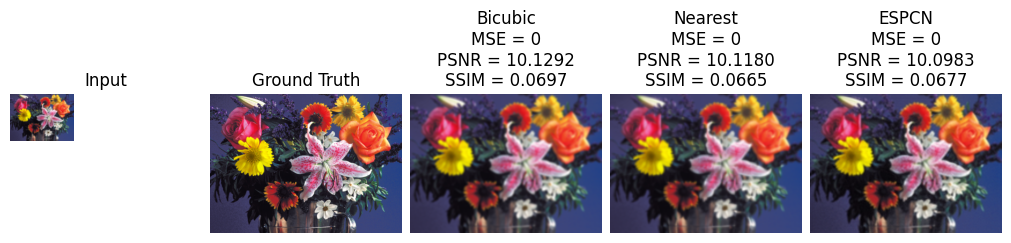

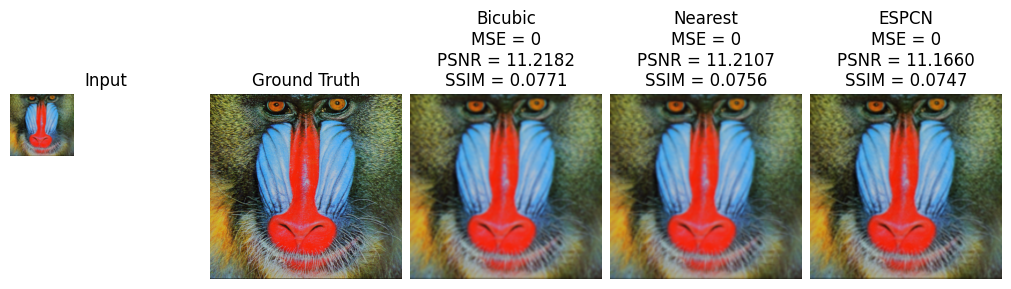

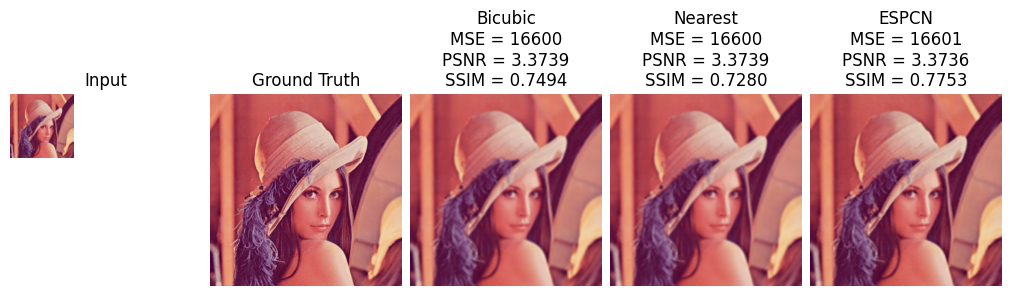

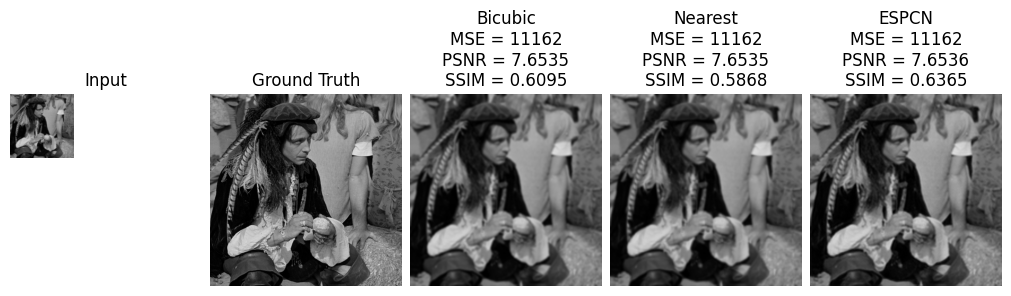

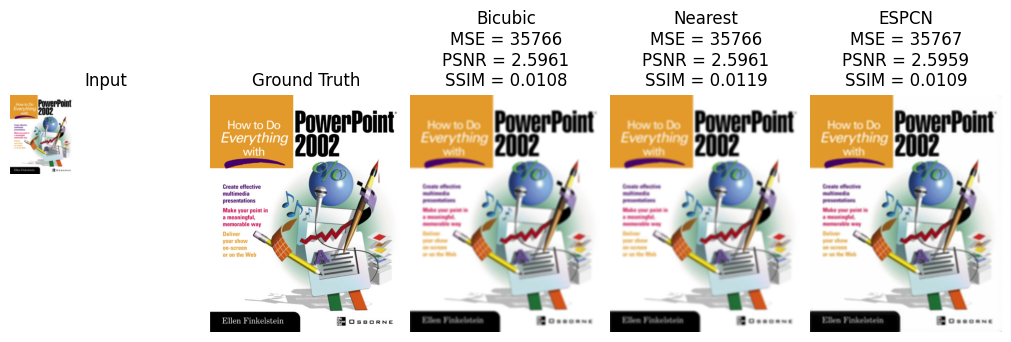

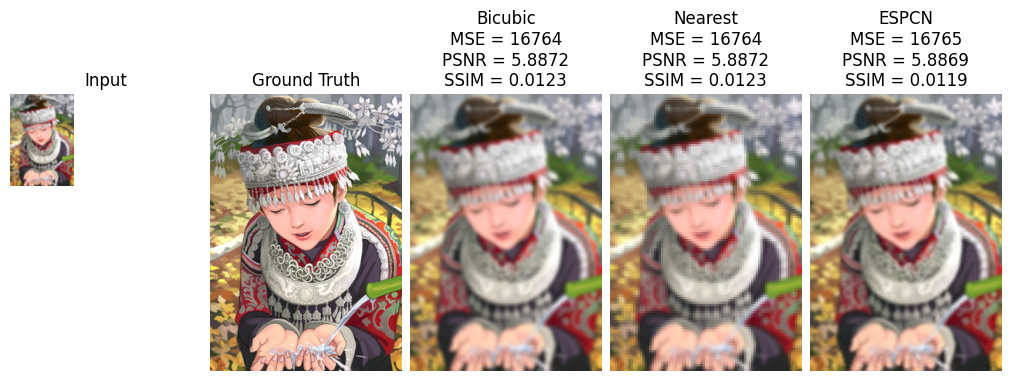

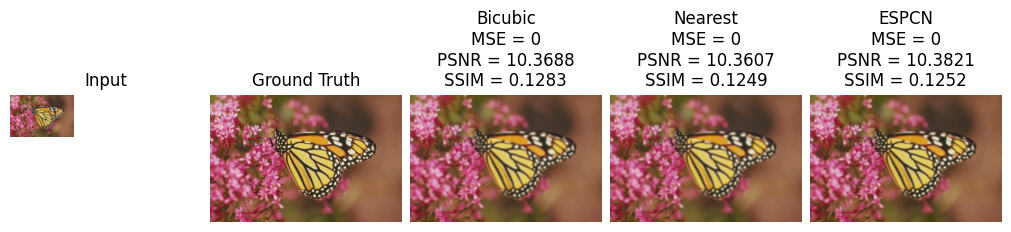

In [ ]:
from supresolv.eval import eval_model

set5_path = "Images/Set5"
# images = os.listdir(set5_path)

images = [os.path.join(set5_path, img) for img in os.listdir(set5_path)]
x = eval_model(
    *images,
    upscale_factor=3,
    model=f".models/model-100-ups-{upscale_factor:02d}-mse.pth",
)

for data in x:
    # print(data['espcn'])

    # print(data)
    fig, axs = plt.subplots(
        1, 5, figsize=(10, 4), constrained_layout=True, sharex=True, sharey=True
    )
    ax_iter = iter(axs)

    ax = next(ax_iter)
    ax.imshow(data["input"]["img"])
    ax.set_title("Input")

    ax = next(ax_iter)
    ax.imshow(data["target"]["img"])
    ax.set_title("Ground Truth")

    ax = next(ax_iter)
    ax.imshow(data["bicubic"]["img"])
    ax.set_title(
        "Bicubic\nMSE = {:.0f}\nPSNR = {:.4f}\nSSIM = {:.4f}".format(
            data["bicubic"]["mse"], data["bicubic"]["psnr"], data["bicubic"]["ssim"]
        )
    )

    ax = next(ax_iter)
    ax.imshow(data["nearest"]["img"])
    ax.set_title(
        "Nearest\nMSE = {:.0f}\nPSNR = {:.4f}\nSSIM = {:.4f}".format(
            data["nearest"]["mse"], data["nearest"]["psnr"], data["nearest"]["ssim"]
        )
    )

    ax = next(ax_iter)
    ax.imshow(data["espcn"]["img"])
    ax.set_title(
        "ESPCN\nMSE = {:.0f}\nPSNR = {:.4f}\nSSIM = {:.4f}".format(
            data["espcn"]["mse"], data["espcn"]["psnr"], data["espcn"]["ssim"]
        )
    )
    # ax = next(ax_iter)
    # x = data['nearest']
    # ax.imshow(data['nearest']['img'])
    # ax.set_title("Nearest\nMSE={:.3f}\nPSNR={:.3f}".format(x['mse'], x['psnr']))

    # ax = next(ax_iter)
    # ax.imshow(data['espcn'])
    # ax.set_title(f"ESPCN\n{psnr = :.4f}\n{mse = :.0f}")

    for ax in axs:
        ax.axis("off")  # remove the ticks

    # plt.show()

(1200, 640)


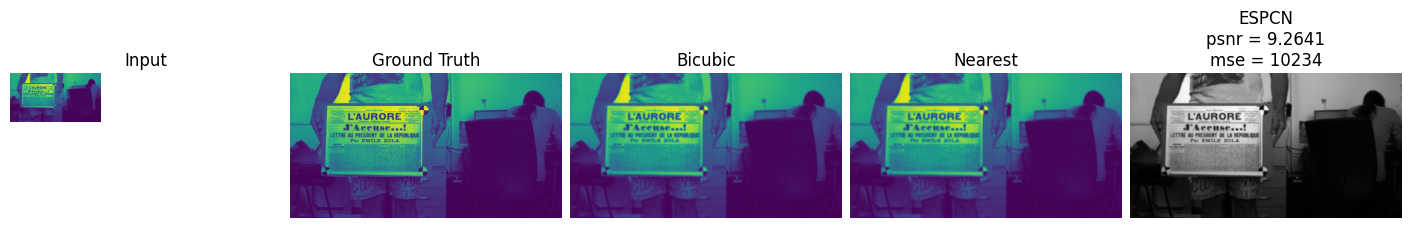

In [6]:
upscale_factor = 3
model = torch.load(
    f".models/model-100-ups-{upscale_factor:02d}-mse.pth", weights_only=False
)

for img in images:
    # img = os.path.join(set5_path, img)

    x = load_img(img)
    print(x.size)
    crop_size_h, crop_size_v = list(
        map(
            lambda size: calculate_valid_crop_size(size, upscale_factor=upscale_factor),
            x.size,
        )
    )

    target = torchvision.transforms.functional.to_tensor(load_img(img))
    target = torchvision.transforms.functional.center_crop(
        target, (crop_size_h, crop_size_v)
    )

    img_original = PIL.Image.open(img).copy()
    img_in = downsample_image(
        img, out="tmp/my_downsampled_image.jpg", factor=upscale_factor
    )
    fp_in = "tmp/my_downsampled_image.jpg"

    input, cb, cr = image_to_input(
        img_in.convert("YCbCr")
    )  # <-- somehow .convert("YCbCr") makes the result much better, must be a problem with reading from file
    model.to("cpu")
    out = model(input)
    img_out = output_to_image(out, cb, cr)

    psnr = peak_signal_noise_ratio(
        target.view(crop_size_h, crop_size_v), out.view(crop_size_h, crop_size_v)
    ).item()
    mse = mean_squared_error(
        target.view(crop_size_h, crop_size_v), out.view(crop_size_h, crop_size_v)
    ).item()

    img_bicubic = img_in.resize(img_out.size, PIL.Image.Resampling.BICUBIC)
    img_nearest = img_in.resize(img_out.size, PIL.Image.Resampling.NEAREST)

    img_out.save("tmp/asd.jpg")

    fig, axs = plt.subplots(
        1, 5, figsize=(14, 24), constrained_layout=True, sharex=True, sharey=True
    )
    ax_iter = iter(axs)

    ax = next(ax_iter)
    ax.imshow(img_in)
    ax.set_title("Input")
    ax = next(ax_iter)
    ax.imshow(img_original)
    ax.set_title("Ground Truth")

    ax = next(ax_iter)
    ax.imshow(img_bicubic)
    ax.set_title("Bicubic")

    ax = next(ax_iter)
    ax.imshow(img_nearest)
    ax.set_title("Nearest")

    ax = next(ax_iter)
    ax.imshow(img_out)
    ax.set_title(f"ESPCN\n{psnr = :.4f}\n{mse = :.0f}")

    for ax in axs:
        ax.axis("off")  # remove the ticks

    plt.show()

### Filters visualization

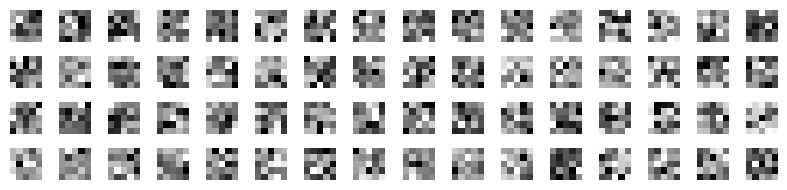

In [7]:
model: ESPCN = torch.load(".models/model-100-ups-03-mse.pth", weights_only=False)
model.to("cpu")


# first layer filter
filters = model.conv1.weight.detach()

grid_size = len(filters)

fig, axes = plt.subplots(4, 16, figsize=(8, 2))

for i, ax in enumerate(axes.flat):
    ax.imshow(filters[i][0].numpy(), cmap="gray")
    ax.axis("off")


plt.tight_layout()
plt.show()

IndexError: index 32 is out of bounds for dimension 0 with size 32

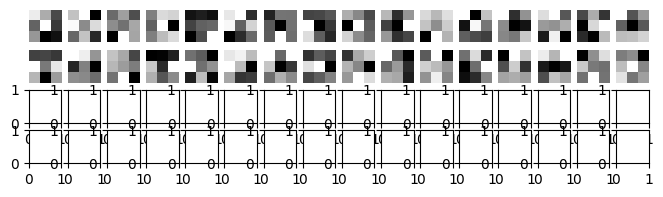

In [8]:
# second layer filter
filters = model.conv2.weight.detach()

grid_size = len(filters) 
fig, axes = plt.subplots(4, 16, figsize=(8, 2))

for i, ax in enumerate(axes.flat):
    ax.imshow(filters[i][0].numpy(), cmap='gray')  
    ax.axis('off') 


plt.tight_layout()
plt.show()